# Imports

In [1]:
import importlib
import sys
import torch

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')

# Data

### Load Data Files

In [2]:
# Path to your pickle file (saved with torch.save)
file_path_train = '../../../../encoded_data/PCR_5_train.pkl'
# Load the dataset using torch.load
PCR_train_dataset = torch.load(file_path_train, weights_only=False)
# Check the type of the loaded dataset
print(type(PCR_train_dataset))  # Should output something like <class 'torch.utils.data.dataset.TensorDataset'>

# Path to your pickle file (saved with torch.save)
file_path_val = '../../../../encoded_data/PCR_5_val.pkl'
# Load the dataset using torch.load
PCR_val_dataset = torch.load(file_path_val, weights_only=False)
# Check the type of the loaded dataset
print(type(PCR_val_dataset))  # Should output something like <class 'torch.utils.data.dataset.TensorDataset'>

<class 'event_log_loader.new_event_log_loader.EventLogDataset'>


<class 'event_log_loader.new_event_log_loader.EventLogDataset'>


### Train Data Insights

In [3]:
# PCR Dataset Categories, Features:

PCR_all_categories = PCR_train_dataset.all_categories

PCR_all_categories_cat = PCR_all_categories[0]
print(PCR_all_categories_cat)

PCR_all_categories_num = PCR_all_categories[1]
print(PCR_all_categories_num)

for i, cat in enumerate(PCR_all_categories_cat):
     print(f"PCR (5) Categorical feature: {cat[0]}, Index position in categorical data list: {i}")
     print(f"PCR (5) Total Amount of Category labels: {cat[1]}")
print('\n')    
for i, num in enumerate(PCR_all_categories_num):
     print(f"PCR (5) Numerical feature: {num[0]}, Index position in categorical data list: {i}")
     print(f"PCR (5) Amount Category Lables: {num[1]}")

[('concept:name', 10, {'Callback timeout': 1, 'EOS': 2, 'Export result': 3, 'Export to EMS': 4, 'Match patient data': 5, 'Receive sample state': 6, 'Send notification': 7, 'Wait for plate validation': 8, 'timeout': 9}), ('cpee:lifecycle:transition', 6, {'EOS': 1, 'activity/calling': 2, 'activity/done': 3, 'activity/receiving': 4, 'dataelements/change': 5})]
[('case_elapsed_time', 1, {}), ('event_elapsed_time', 1, {}), ('day_in_week', 1, {}), ('seconds_in_day', 1, {})]
PCR (5) Categorical feature: concept:name, Index position in categorical data list: 0
PCR (5) Total Amount of Category labels: 10
PCR (5) Categorical feature: cpee:lifecycle:transition, Index position in categorical data list: 1
PCR (5) Total Amount of Category labels: 6


PCR (5) Numerical feature: case_elapsed_time, Index position in categorical data list: 0
PCR (5) Amount Category Lables: 1
PCR (5) Numerical feature: event_elapsed_time, Index position in categorical data list: 1
PCR (5) Amount Category Lables: 1
PCR (5

### Input Features for Encoder and Decoder

In [4]:
# Create lists with name of Encoder features (input) and decoder features (input & output)

# Encoder features:
enc_feat_cat = []
enc_feat_num = []
for cat in PCR_all_categories_cat:
    enc_feat_cat.append(cat[0])
for num in PCR_all_categories_num:
    enc_feat_num.append(num[0])
enc_feat = [enc_feat_cat, enc_feat_num]
print("Input features encoder: ", enc_feat)

"""
# Decoder features:
dec_feat_cat = enc_feat_cat
dec_feat_num = enc_feat_num
dec_feat = [dec_feat_cat, dec_feat_num]
print("Features decoder: ", dec_feat)
"""

# Decoder features:
dec_feat_cat = ['concept:name']
dec_feat_num = ['case_elapsed_time', 'event_elapsed_time']
dec_feat = [dec_feat_cat, dec_feat_num]
print("Features decoder: ", dec_feat)

Input features encoder:  [['concept:name', 'cpee:lifecycle:transition'], ['case_elapsed_time', 'event_elapsed_time', 'day_in_week', 'seconds_in_day']]
Features decoder:  [['concept:name'], ['case_elapsed_time', 'event_elapsed_time']]


# Model

In [5]:
import model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model
importlib.reload(model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model)
from model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model import DropoutUncertaintyEncoderDecoderLSTM

# Prediction decoder output sequence length
seq_len_pred = 4

# Size hidden layer
hidden_size = 128

# Number of cells
num_layers = 4

# Fixed Dropout probability 
dropout = 0.1

# Encoder Decoder model initialization
model = DropoutUncertaintyEncoderDecoderLSTM(data_set_categories=PCR_all_categories,
                                             enc_feat=enc_feat,
                                             dec_feat=dec_feat,
                                             seq_len_pred=seq_len_pred,
                                             hidden_size=hidden_size,
                                             num_layers=num_layers,
                                             dropout=dropout)

Data set categories:  ([('concept:name', 10, {'Callback timeout': 1, 'EOS': 2, 'Export result': 3, 'Export to EMS': 4, 'Match patient data': 5, 'Receive sample state': 6, 'Send notification': 7, 'Wait for plate validation': 8, 'timeout': 9}), ('cpee:lifecycle:transition', 6, {'EOS': 1, 'activity/calling': 2, 'activity/done': 3, 'activity/receiving': 4, 'dataelements/change': 5})], [('case_elapsed_time', 1, {}), ('event_elapsed_time', 1, {}), ('day_in_week', 1, {}), ('seconds_in_day', 1, {})])
Encoder input features:  [['concept:name', 'cpee:lifecycle:transition'], ['case_elapsed_time', 'event_elapsed_time', 'day_in_week', 'seconds_in_day']]
Decoder input+output features:  [['concept:name'], ['case_elapsed_time', 'event_elapsed_time']]


Sequence length of decoder output:  4


Cells hidden size:  128
Number of LSTM layer:  4
Dropout rate:  0.1


Encoder number of labels for each input feature (categorical, numerical):  [[10, 6], [1, 1, 1, 1]]
Encoder indices of tensors in dataset used a

# Loss Object Creation

In [6]:
import loss.losses
importlib.reload(loss.losses)
from loss.losses import Loss

loss_obj = Loss()

# Numerical features trained with log-normal loss:
log_normal_loss_num_feature = ['case_elapsed_time', 'event_elapsed_time']

# Training Configuration

In [7]:
import trainer.trainer
importlib.reload(trainer.trainer)
from trainer.trainer import Trainer
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(comment="Full_PCR_grad")

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start learning rate
learning_rate = 1e-4

# Optimizer and Scheduler
# optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=2, min_lr=1e-9)

# Epochs
num_epochs = 100

# Batch size
batch_size = 128

# lambda for L2 (weight, bias, dropout) regularization: According to formula: 1/2N
# regularization_term = 1.0/(2.0*batch_size)
regularization_term =  1e-4

# shuffle data
shuffle = True

# Teacher forcing: Smaller 0.5 more predicted events are used for next event prediction.
teacher_forcing_ratio = 0.8

optimize_values = {"regularization_term":regularization_term,
                   "optimizer":optimizer,
                   "scheduler": scheduler,
                   "epochs":num_epochs,
                   "mini_batches":batch_size,
                   "shuffle": shuffle,
                   "teacher_forcing_ratio":teacher_forcing_ratio,}

suffix_data_split_value = 4

# GradNorm parameter
use_gradnorm = True
gn_alpha = 1.5
gn_learning_rate = 1e-4
# gn_learning_rate =  0.025

number_tasks = len(dec_feat[0]) + len(dec_feat[1])

gradNorm = {"use_gradnorm":use_gradnorm,
            "number_tasks": number_tasks,
            "gn_alpha":gn_alpha,
            "gn_learning_rate": gn_learning_rate}

trainer = Trainer(device=device,
                  model=model,
                  data_train=PCR_train_dataset,
                  data_val=PCR_val_dataset,
                  loss_obj=loss_obj,
                  log_normal_loss_num_feature = log_normal_loss_num_feature,
                  optimize_values=optimize_values,
                  suffix_data_split_value=suffix_data_split_value,
                  writer=writer,
                  gradnorm_values=gradNorm,
                  save_model_n_th_epoch = 1,
                  saving_path = 'PCR_full_grad_norm_new_4layer.pkl')

# Train the model:
train_attenuated_losses, val_losses, val_attenuated_losses = trainer.train_model()

Device:  cuda


Model:  DropoutUncertaintyEncoderDecoderLSTM(
  (embeddings_enc): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(6, 4)
  )
  (encoder): DropoutUncertaintyLSTMEncoder(
    (embeddings): ModuleList(
      (0): Embedding(10, 6)
      (1): Embedding(6, 4)
    )
    (first_layer): DropoutUncertaintyLSTMCell(
      (Wi): Linear(in_features=14, out_features=128, bias=True)
      (Ui): Linear(in_features=128, out_features=128, bias=True)
      (Wf): Linear(in_features=14, out_features=128, bias=True)
      (Uf): Linear(in_features=128, out_features=128, bias=True)
      (Wc): Linear(in_features=14, out_features=128, bias=True)
      (Uc): Linear(in_features=128, out_features=128, bias=True)
      (Wo): Linear(in_features=14, out_features=128, bias=True)
      (Uo): Linear(in_features=128, out_features=128, bias=True)
    )
    (hidden_layers): ModuleList(
      (0-2): 3 x DropoutUncertaintyLSTMCell(
        (Wi): Linear(in_features=128, out_features=128, bias=True)
        (Ui): Line

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 2.4718


Validation: Avg Standard Validation Loss: 3.4021
Validation: Avg Attenuated Validation Loss: 4.0696
Validation Loss for Scheduler: 3.4021
saving model


Epoch [2/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 0.8172


Validation: Avg Standard Validation Loss: 3.0227
Validation: Avg Attenuated Validation Loss: 11.5945
Validation Loss for Scheduler: 3.0227
saving model


Epoch [3/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 0.3802


Validation: Avg Standard Validation Loss: 2.7704
Validation: Avg Attenuated Validation Loss: 7.3163
Validation Loss for Scheduler: 2.7704
saving model


Epoch [4/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.0662


Validation: Avg Standard Validation Loss: 2.6664
Validation: Avg Attenuated Validation Loss: 10.1068
Validation Loss for Scheduler: 2.6664
saving model


Epoch [5/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.5688


Validation: Avg Standard Validation Loss: 2.5998
Validation: Avg Attenuated Validation Loss: 13.2880
Validation Loss for Scheduler: 2.5998
saving model


Epoch [6/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.3429


Validation: Avg Standard Validation Loss: 2.5265
Validation: Avg Attenuated Validation Loss: 16.3067
Validation Loss for Scheduler: 2.5265
saving model


Epoch [7/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 0.1717


Validation: Avg Standard Validation Loss: 2.4710
Validation: Avg Attenuated Validation Loss: 20.5610
Validation Loss for Scheduler: 2.4710
saving model


Epoch [8/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.3820


Validation: Avg Standard Validation Loss: 2.4234
Validation: Avg Attenuated Validation Loss: 17.9021
Validation Loss for Scheduler: 2.4234
saving model


Epoch [9/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.8625


Validation: Avg Standard Validation Loss: 2.4477
Validation: Avg Attenuated Validation Loss: 26.9472
Validation Loss for Scheduler: 2.4477
saving model


Epoch [10/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.3637


Validation: Avg Standard Validation Loss: 2.3553
Validation: Avg Attenuated Validation Loss: 18.9680
Validation Loss for Scheduler: 2.3553
saving model


Epoch [11/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 0.3747


Validation: Avg Standard Validation Loss: 2.3102
Validation: Avg Attenuated Validation Loss: 30.8297
Validation Loss for Scheduler: 2.3102
saving model


Epoch [12/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 2.3043


Validation: Avg Standard Validation Loss: 2.3533
Validation: Avg Attenuated Validation Loss: 40.2846
Validation Loss for Scheduler: 2.3533
saving model


Epoch [13/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 1.1981


Validation: Avg Standard Validation Loss: 2.3157
Validation: Avg Attenuated Validation Loss: 42.7472
Validation Loss for Scheduler: 2.3157
saving model


Epoch [14/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 8.8234


Validation: Avg Standard Validation Loss: 2.2516
Validation: Avg Attenuated Validation Loss: 27.2568
Validation Loss for Scheduler: 2.2516
saving model


Epoch [15/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 27.7567


Validation: Avg Standard Validation Loss: 2.2312
Validation: Avg Attenuated Validation Loss: 63.6886
Validation Loss for Scheduler: 2.2312
saving model


Epoch [16/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 28.6783


Validation: Avg Standard Validation Loss: 2.2287
Validation: Avg Attenuated Validation Loss: 46.6641
Validation Loss for Scheduler: 2.2287
saving model


Epoch [17/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 14.6452


Validation: Avg Standard Validation Loss: 2.2654
Validation: Avg Attenuated Validation Loss: 38.4383
Validation Loss for Scheduler: 2.2654
saving model


Epoch [18/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 15.4509


Validation: Avg Standard Validation Loss: 2.2417
Validation: Avg Attenuated Validation Loss: 58.8337
Validation Loss for Scheduler: 2.2417
saving model


Epoch [19/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 4.3406


Validation: Avg Standard Validation Loss: 2.2111
Validation: Avg Attenuated Validation Loss: 54.3149
Validation Loss for Scheduler: 2.2111
saving model


Epoch [20/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 10.2370


Validation: Avg Standard Validation Loss: 2.1841
Validation: Avg Attenuated Validation Loss: 42.4394
Validation Loss for Scheduler: 2.1841
saving model


Epoch [21/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 31.3507


Validation: Avg Standard Validation Loss: 2.2224
Validation: Avg Attenuated Validation Loss: 43.1733
Validation Loss for Scheduler: 2.2224
saving model


Epoch [22/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 32.6828


Validation: Avg Standard Validation Loss: 2.1873
Validation: Avg Attenuated Validation Loss: 31.1307
Validation Loss for Scheduler: 2.1873
saving model


Epoch [23/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 20.8112


Validation: Avg Standard Validation Loss: 2.2266
Validation: Avg Attenuated Validation Loss: 58.8342
Validation Loss for Scheduler: 2.2266
saving model


Epoch [24/100], Learning Rate: 1.0000000000000002e-06, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 32.7932


Validation: Avg Standard Validation Loss: 2.1966
Validation: Avg Attenuated Validation Loss: 53.3474
Validation Loss for Scheduler: 2.1966
saving model


Epoch [25/100], Learning Rate: 1.0000000000000002e-06, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 29.7789


Validation: Avg Standard Validation Loss: 2.1987
Validation: Avg Attenuated Validation Loss: 65.3512
Validation Loss for Scheduler: 2.1987
saving model


Epoch [26/100], Learning Rate: 1.0000000000000002e-06, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 30.3783


Validation: Avg Standard Validation Loss: 2.1866
Validation: Avg Attenuated Validation Loss: 50.8840
Validation Loss for Scheduler: 2.1866
saving model


Epoch [27/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 31.7340


Validation: Avg Standard Validation Loss: 2.1826
Validation: Avg Attenuated Validation Loss: 58.6701
Validation Loss for Scheduler: 2.1826
saving model


Epoch [28/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 30.8583


Validation: Avg Standard Validation Loss: 2.2077
Validation: Avg Attenuated Validation Loss: 61.5868
Validation Loss for Scheduler: 2.2077
saving model


Epoch [29/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 30.3891


Validation: Avg Standard Validation Loss: 2.1798
Validation: Avg Attenuated Validation Loss: 52.4961
Validation Loss for Scheduler: 2.1798
saving model


Epoch [30/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 30.7816


Validation: Avg Standard Validation Loss: 2.1888
Validation: Avg Attenuated Validation Loss: 54.6355
Validation Loss for Scheduler: 2.1888
saving model


Epoch [31/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 33.0602


Validation: Avg Standard Validation Loss: 2.1783
Validation: Avg Attenuated Validation Loss: 54.6755
Validation Loss for Scheduler: 2.1783
saving model


Epoch [32/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 33.1028


Validation: Avg Standard Validation Loss: 2.1892
Validation: Avg Attenuated Validation Loss: 57.9544
Validation Loss for Scheduler: 2.1892
saving model


Epoch [33/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 36.6596


Validation: Avg Standard Validation Loss: 2.1939
Validation: Avg Attenuated Validation Loss: 52.4594
Validation Loss for Scheduler: 2.1939
saving model


Epoch [34/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 32.8252


Validation: Avg Standard Validation Loss: 2.1801
Validation: Avg Attenuated Validation Loss: 51.9689
Validation Loss for Scheduler: 2.1801
saving model


Epoch [35/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 33.2527


Validation: Avg Standard Validation Loss: 2.1881
Validation: Avg Attenuated Validation Loss: 52.1221
Validation Loss for Scheduler: 2.1881
saving model


Epoch [36/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 33.0938


Validation: Avg Standard Validation Loss: 2.1843
Validation: Avg Attenuated Validation Loss: 51.6827
Validation Loss for Scheduler: 2.1843
saving model


Epoch [37/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 35.1214


Validation: Avg Standard Validation Loss: 2.1848
Validation: Avg Attenuated Validation Loss: 55.1191
Validation Loss for Scheduler: 2.1848
saving model


Epoch [38/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 32.3673


Validation: Avg Standard Validation Loss: 2.2059
Validation: Avg Attenuated Validation Loss: 56.1270
Validation Loss for Scheduler: 2.2059
saving model


Epoch [39/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 34.3213


Validation: Avg Standard Validation Loss: 2.1771
Validation: Avg Attenuated Validation Loss: 52.8813
Validation Loss for Scheduler: 2.1771
saving model


Epoch [40/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.768
Training: Avg Attenuated Training Loss: 35.5101


Validation: Avg Standard Validation Loss: 2.1812
Validation: Avg Attenuated Validation Loss: 51.6350
Validation Loss for Scheduler: 2.1812
saving model


Epoch [41/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 36.8706


Validation: Avg Standard Validation Loss: 2.1830
Validation: Avg Attenuated Validation Loss: 53.8844
Validation Loss for Scheduler: 2.1830
saving model


Epoch [42/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 34.7530


Validation: Avg Standard Validation Loss: 2.1868
Validation: Avg Attenuated Validation Loss: 51.7104
Validation Loss for Scheduler: 2.1868
saving model


Epoch [43/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 37.6066


Validation: Avg Standard Validation Loss: 2.1922
Validation: Avg Attenuated Validation Loss: 52.7987
Validation Loss for Scheduler: 2.1922
saving model


Epoch [44/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 38.1036


Validation: Avg Standard Validation Loss: 2.2110
Validation: Avg Attenuated Validation Loss: 52.0216
Validation Loss for Scheduler: 2.2110
saving model


Epoch [45/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 35.7354


Validation: Avg Standard Validation Loss: 2.1786
Validation: Avg Attenuated Validation Loss: 52.8227
Validation Loss for Scheduler: 2.1786
saving model


Epoch [46/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 36.5796


Validation: Avg Standard Validation Loss: 2.1849
Validation: Avg Attenuated Validation Loss: 51.7067
Validation Loss for Scheduler: 2.1849
saving model


Epoch [47/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 38.3348


Validation: Avg Standard Validation Loss: 2.1843
Validation: Avg Attenuated Validation Loss: 53.3377
Validation Loss for Scheduler: 2.1843
saving model


Epoch [48/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 36.6602


Validation: Avg Standard Validation Loss: 2.1898
Validation: Avg Attenuated Validation Loss: 51.5535
Validation Loss for Scheduler: 2.1898
saving model


Epoch [49/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 38.6491


Validation: Avg Standard Validation Loss: 2.1862
Validation: Avg Attenuated Validation Loss: 54.9088
Validation Loss for Scheduler: 2.1862
saving model


Epoch [50/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 36.4700


Validation: Avg Standard Validation Loss: 2.1943
Validation: Avg Attenuated Validation Loss: 53.3411
Validation Loss for Scheduler: 2.1943
saving model


Epoch [51/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 36.7076


Validation: Avg Standard Validation Loss: 2.1825
Validation: Avg Attenuated Validation Loss: 53.3074
Validation Loss for Scheduler: 2.1825
saving model


Epoch [52/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 34.8675


Validation: Avg Standard Validation Loss: 2.1855
Validation: Avg Attenuated Validation Loss: 53.8776
Validation Loss for Scheduler: 2.1855
saving model


Epoch [53/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 38.1180


Validation: Avg Standard Validation Loss: 2.1849
Validation: Avg Attenuated Validation Loss: 53.3063
Validation Loss for Scheduler: 2.1849
saving model


Epoch [54/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 37.7427


Validation: Avg Standard Validation Loss: 2.1806
Validation: Avg Attenuated Validation Loss: 54.6624
Validation Loss for Scheduler: 2.1806
saving model


Epoch [55/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 36.3918


Validation: Avg Standard Validation Loss: 2.1757
Validation: Avg Attenuated Validation Loss: 60.3720
Validation Loss for Scheduler: 2.1757
saving model


Epoch [56/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 35.7380


Validation: Avg Standard Validation Loss: 2.1855
Validation: Avg Attenuated Validation Loss: 56.4985
Validation Loss for Scheduler: 2.1855
saving model


Epoch [57/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 39.8905


Validation: Avg Standard Validation Loss: 2.1758
Validation: Avg Attenuated Validation Loss: 55.9824
Validation Loss for Scheduler: 2.1758
saving model


Epoch [58/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 37.3640


Validation: Avg Standard Validation Loss: 2.1866
Validation: Avg Attenuated Validation Loss: 51.7968
Validation Loss for Scheduler: 2.1866
saving model


Epoch [59/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 37.3746


Validation: Avg Standard Validation Loss: 2.2367
Validation: Avg Attenuated Validation Loss: 63.3161
Validation Loss for Scheduler: 2.2367
saving model


Epoch [60/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.73728
Training: Avg Attenuated Training Loss: 36.8851


Validation: Avg Standard Validation Loss: 2.1844
Validation: Avg Attenuated Validation Loss: 50.7589
Validation Loss for Scheduler: 2.1844
saving model


Epoch [61/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 36.5314


Validation: Avg Standard Validation Loss: 2.1844
Validation: Avg Attenuated Validation Loss: 51.7995
Validation Loss for Scheduler: 2.1844
saving model


Epoch [62/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 40.2195


Validation: Avg Standard Validation Loss: 2.1828
Validation: Avg Attenuated Validation Loss: 52.4660
Validation Loss for Scheduler: 2.1828
saving model


Epoch [63/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 37.6787


Validation: Avg Standard Validation Loss: 2.1869
Validation: Avg Attenuated Validation Loss: 52.6108
Validation Loss for Scheduler: 2.1869
saving model


Epoch [64/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 41.1588


Validation: Avg Standard Validation Loss: 2.1924
Validation: Avg Attenuated Validation Loss: 51.8030
Validation Loss for Scheduler: 2.1924
saving model


Epoch [65/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 40.0970


Validation: Avg Standard Validation Loss: 2.1816
Validation: Avg Attenuated Validation Loss: 54.5058
Validation Loss for Scheduler: 2.1816
saving model


Epoch [66/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 38.2317


Validation: Avg Standard Validation Loss: 2.2477
Validation: Avg Attenuated Validation Loss: 54.0486
Validation Loss for Scheduler: 2.2477
saving model


Epoch [67/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 38.7204


Validation: Avg Standard Validation Loss: 2.1792
Validation: Avg Attenuated Validation Loss: 60.3509
Validation Loss for Scheduler: 2.1792
saving model


Epoch [68/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 37.4211


Validation: Avg Standard Validation Loss: 2.1798
Validation: Avg Attenuated Validation Loss: 51.4899
Validation Loss for Scheduler: 2.1798
saving model


Epoch [69/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 37.8647


Validation: Avg Standard Validation Loss: 2.1811
Validation: Avg Attenuated Validation Loss: 52.6191
Validation Loss for Scheduler: 2.1811
saving model


Epoch [70/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 37.3760


Validation: Avg Standard Validation Loss: 2.1836
Validation: Avg Attenuated Validation Loss: 52.1416
Validation Loss for Scheduler: 2.1836
saving model


Epoch [71/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 36.2512


Validation: Avg Standard Validation Loss: 2.1876
Validation: Avg Attenuated Validation Loss: 60.3804
Validation Loss for Scheduler: 2.1876
saving model


Epoch [72/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 37.3473


Validation: Avg Standard Validation Loss: 2.2082
Validation: Avg Attenuated Validation Loss: 57.9321
Validation Loss for Scheduler: 2.2082
saving model


Epoch [73/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 37.2816


Validation: Avg Standard Validation Loss: 2.1858
Validation: Avg Attenuated Validation Loss: 53.0557
Validation Loss for Scheduler: 2.1858
saving model


Epoch [74/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 37.2309


Validation: Avg Standard Validation Loss: 2.1780
Validation: Avg Attenuated Validation Loss: 54.6394
Validation Loss for Scheduler: 2.1780
saving model


Epoch [75/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 37.2149


Validation: Avg Standard Validation Loss: 2.4610
Validation: Avg Attenuated Validation Loss: 53.8307
Validation Loss for Scheduler: 2.4610
saving model


Epoch [76/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 39.6077


Validation: Avg Standard Validation Loss: 2.1756
Validation: Avg Attenuated Validation Loss: 53.1681
Validation Loss for Scheduler: 2.1756
saving model


Epoch [77/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 38.0453


Validation: Avg Standard Validation Loss: 2.1808
Validation: Avg Attenuated Validation Loss: 63.3818
Validation Loss for Scheduler: 2.1808
saving model


Epoch [78/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 40.2583


Validation: Avg Standard Validation Loss: 2.1893
Validation: Avg Attenuated Validation Loss: 56.5801
Validation Loss for Scheduler: 2.1893
saving model


Epoch [79/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 35.7171


Validation: Avg Standard Validation Loss: 2.1775
Validation: Avg Attenuated Validation Loss: 52.1344
Validation Loss for Scheduler: 2.1775
saving model


Epoch [80/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.7077888
Training: Avg Attenuated Training Loss: 37.7311


Validation: Avg Standard Validation Loss: 2.1795
Validation: Avg Attenuated Validation Loss: 51.4762
Validation Loss for Scheduler: 2.1795
saving model


Epoch [81/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 38.7981


Validation: Avg Standard Validation Loss: 2.1766
Validation: Avg Attenuated Validation Loss: 52.4318
Validation Loss for Scheduler: 2.1766
saving model


Epoch [82/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 37.4944


Validation: Avg Standard Validation Loss: 2.1802
Validation: Avg Attenuated Validation Loss: 57.6937
Validation Loss for Scheduler: 2.1802
saving model


Epoch [83/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 38.3767


Validation: Avg Standard Validation Loss: 2.1862
Validation: Avg Attenuated Validation Loss: 59.8965
Validation Loss for Scheduler: 2.1862
saving model


Epoch [84/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 37.4435


Validation: Avg Standard Validation Loss: 2.1778
Validation: Avg Attenuated Validation Loss: 52.6905
Validation Loss for Scheduler: 2.1778
saving model


Epoch [85/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 36.6945


Validation: Avg Standard Validation Loss: 2.1843
Validation: Avg Attenuated Validation Loss: 51.7791
Validation Loss for Scheduler: 2.1843
saving model


Epoch [86/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 38.2579


Validation: Avg Standard Validation Loss: 2.1815
Validation: Avg Attenuated Validation Loss: 52.5040
Validation Loss for Scheduler: 2.1815
saving model


Epoch [87/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 39.0893


Validation: Avg Standard Validation Loss: 2.1908
Validation: Avg Attenuated Validation Loss: 53.5955
Validation Loss for Scheduler: 2.1908
saving model


Epoch [88/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 39.7114


Validation: Avg Standard Validation Loss: 2.1800
Validation: Avg Attenuated Validation Loss: 60.1935
Validation Loss for Scheduler: 2.1800
saving model


Epoch [89/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 36.2853


Validation: Avg Standard Validation Loss: 2.2312
Validation: Avg Attenuated Validation Loss: 49.9593
Validation Loss for Scheduler: 2.2312
saving model


Epoch [90/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 38.8717


Validation: Avg Standard Validation Loss: 2.2084
Validation: Avg Attenuated Validation Loss: 52.3417
Validation Loss for Scheduler: 2.2084
saving model


Epoch [91/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 37.6327


Validation: Avg Standard Validation Loss: 2.2338
Validation: Avg Attenuated Validation Loss: 58.5345
Validation Loss for Scheduler: 2.2338
saving model


Epoch [92/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 37.7417


Validation: Avg Standard Validation Loss: 2.1900
Validation: Avg Attenuated Validation Loss: 52.8709
Validation Loss for Scheduler: 2.1900
saving model


Epoch [93/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 35.0525


Validation: Avg Standard Validation Loss: 2.1876
Validation: Avg Attenuated Validation Loss: 51.9130
Validation Loss for Scheduler: 2.1876
saving model


Epoch [94/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 38.0076


Validation: Avg Standard Validation Loss: 2.1771
Validation: Avg Attenuated Validation Loss: 52.1691
Validation Loss for Scheduler: 2.1771
saving model


Epoch [95/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 41.0241


Validation: Avg Standard Validation Loss: 2.1781
Validation: Avg Attenuated Validation Loss: 53.7041
Validation Loss for Scheduler: 2.1781
saving model


Epoch [96/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 36.3679


Validation: Avg Standard Validation Loss: 2.1880
Validation: Avg Attenuated Validation Loss: 58.8850
Validation Loss for Scheduler: 2.1880
saving model


Epoch [97/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 36.0530


Validation: Avg Standard Validation Loss: 2.1786
Validation: Avg Attenuated Validation Loss: 51.6173
Validation Loss for Scheduler: 2.1786
saving model


Epoch [98/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 37.9515


Validation: Avg Standard Validation Loss: 2.1858
Validation: Avg Attenuated Validation Loss: 52.3202
Validation Loss for Scheduler: 2.1858
saving model


Epoch [99/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 35.0147


Validation: Avg Standard Validation Loss: 2.1831
Validation: Avg Attenuated Validation Loss: 50.8830
Validation Loss for Scheduler: 2.1831
saving model


Epoch [100/100], Learning Rate: 1.0000000000000002e-08, Teacher forcing ratio: 0.679477248
Training: Avg Attenuated Training Loss: 35.8586


Validation: Avg Standard Validation Loss: 2.1757
Validation: Avg Attenuated Validation Loss: 51.4449
Validation Loss for Scheduler: 2.1757
saving model
Training complete.
Model saved to path: PCR_full_grad_norm_new_4layer.pkl


# Training Visualization

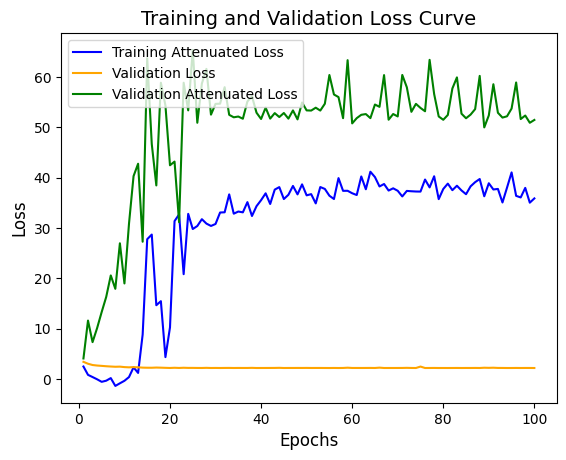

In [8]:
import matplotlib.pyplot as plt

# After training is finished, plot the loss curves
plt.plot(range(1, num_epochs+1), train_attenuated_losses, label='Training Attenuated Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='orange')
plt.plot(range(1, num_epochs+1), val_attenuated_losses, label='Validation Attenuated Loss', color='green')
# Labeling x and y axes
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
# Adding title
plt.title('Training and Validation Loss Curve', fontsize=14)
# Adding legend
plt.legend()
# Show the plot
plt.show()